<a href="https://colab.research.google.com/github/cogitare-aude/ex-datis-scientia/blob/master/Msc_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal: understand how behaviour change in digital groups
* Focus on emotional content of communication
* Management Science research on innovation and culture
* World more digital, companies like Facebook & Shopify are all remote

Using Github as a very established digital group mimicing the org. behavriour of companies, especially tech
* Previous research looks at Github (researched) overall aggregated & focuson on surface level or physical attributes
* This project focuses on one well established Repo (which is more like how a digital company works, ie. not repo to repo), as well as emojis (well researched and sentiment) with 16K issues (mimics company behaviour)

Issue->comments------->contributors
* --------emoji--------- count
* -------sentiment ------how to treat tenured contributors?

## General Start

In [ ]:
#General Code

#give access to My Drive (Google Drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#define path for this project
import os
os.chdir('drive/My Drive/Colab Notebooks/Capstone')

In [ ]:
#install library to manage Github via. Python
%pip install PyGithub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 291 kB 4.9 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 856 kB 9.3 MB/s 


In [ ]:
#Libraries

#for Git API
from github import Github 

#for API sleep timer
import calendar
import time
import datetime

#dealing with website headers
import json
import requests

#regex
import re

#for saving to disk
import pickle

#progress bar
from ipywidgets import IntProgress
from IPython.display import display

#for dynamic printing
#from sys import stdout

import pandas as pd
import numpy as np

#for plotting
import matplotlib.pyplot as plt


In [ ]:
#Github API 

#Github Auth Token (private)
with open('credentials.txt', 'rb') as file:
  lines = file.readlines()
  git_hub_cred = lines[0]
  git_hub_cred = git_hub_cred.decode('utf-8') #decode bytes

#Authenticate to create Github Object (API-auth token)
git_obj = Github(git_hub_cred)

In [ ]:
#Github API limit 
#ref.https://github.com/PyGithub/PyGithub/issues/1319

#system waits until (1-hr) re-set to continue
#time.sleep(sleep_time)

## Save Repo & Issue

In [ ]:

#top 30 repos (defualt page size =30)
repos = results_dict['items']
len(repos)

repo_df = pd.DataFrame(repos)

In [ ]:
real_issues = [issue_content for i in range(round(issues.totalCount / 30) + 1) for issue_content in issues.get_page(i) if not issue_content.pull_request]
#issues-object includes git-issues & pull-requests, only keep real-issues
#ea. page (more issues = more pages) contains a list of issues, only keep issues that are real-git-issues (not PRs)


In [ ]:
rtn = {}
for issue_content in real_issues:
  iss_dict = {"title": issue_content.title, #title of issue
              "body": issue_content.body, #original comment
              "state": issue_content.state,
              "comments": [comment.body for comment in issue_content.get_comments()]} #follow-up comments
  rtn[issue_content.number] = iss_dict


#note:
# ```content``` -> quoted code chunck
# `conetent` -> quoted code line
# _italic_, **bold**, [hyperlink](www.w.com)
# ea. comment after body is separated by "" or ''

In [ ]:
real_issues[0]

Issue(title="Question Importing Data (P1)", number=3)

In [ ]:
for comment in real_issues[0].get_comments():
  print(comment)
  #comment.user
  #comment.created_at
  for reaction in comment.get_reactions():
    print(reaction.content)


IssueComment(user=NamedUser(login="JohannaPferd"), id=974707646)
+1
IssueComment(user=NamedUser(login="cogitare-aude"), id=1153131919)
heart
-1
IssueComment(user=NamedUser(login="cogitare-aude"), id=1153148525)


In [ ]:
reaction.content

'heart'

In [ ]:
#all parsable data from git-issue-comment object
comment.raw_data


In [ ]:
#all parsable data from git-issue object
real_issues[0].raw_data

In [ ]:
#ref. https://stackoverflow.com/questions/57211865/downloading-issues-from-a-public-github-repository

def download_github_issues_as_dict(repo_url, token):
    '''
    since GitHub doesn't make it super easy to download GitHub issues...
    :param repo_url: the full URL of the repo (don't include the trailing "/" nor ".git" suffix).
    :param token: a GitHub Personal Access Token (create from GitHub itself)
    :return: a dictionary that can be easily json-ified with the relevant info from the issues.
    '''

    assert isinstance(repo_url, str) and not repo_url.endswith("/") and repo_url.endswith(".git") and "/" in repo_url , "need proper url: 'https://github.com/repo-owner/repo-name'"
    assert isinstance(token, str), "need str-type unique Github token"

    git_obj = github.Github(token)
    user_str, repo_str = repo_url.replace("https://github.com/", "").split("/")
    user = git_obj.get_user(user_str)
    repo = user.get_repo(repo_str)
    issues = repo.get_issues(state="all")

    # (30 issues per page, find total number of pages that need parsing) the number 30 is hardcoded into the PyGitHub
    real_issues = [_ for i in range(round(issues.totalCount / 30) + 1) for _ in issues.get_page(i) if
                   not _.pull_request]
    rtn = {}
    for iss in real_issues:
        iss_dict = {"title": iss.title,
                    "body": iss.body,
                    "state": iss.state,
                    "comments": [_.body for _ in iss.get_comments()]}
        rtn[iss.number] = iss_dict

    return rtn

In [ ]:
#input url
#repo_url = 'https://github.com/freeCodeCamp/freeCodeCamp'
repo_url = 'https://github.com/lse-my470/assignment-8-centipede'

user_str, repo_str = repo_url.replace("https://github.com/", "").split("/")
user = git_obj.get_user(user_str)
repo = user.get_repo(repo_str)
issues = repo.get_issues(state="all")

#used 2 API

In [ ]:
#pd.DataFrame(repos)

3  \
title                                  Question Importing Data (P1)   
body              during which question /step should we remove t...   
create_dt                                       2021-11-20 19:06:30   
state                                                        closed   
comments          [I agree that we shold remove the first 2 colu...   
comment_user                         [91499393, 35208282, 35208282]   
comment_reaction                                       [+1, +1, +1]   

                                                                  2  
title                                         Question Empty Vector  
body              1. prof seems to always declare vectors with `...  
create_dt                                       2021-11-20 19:04:27  
state                                                        closed  
comments          [I've tried both c(0) and c() in R.\r\nc(0) is...  
comment_user                                             [91499393]  
comment_reaction                                               [+1]

In [ ]:
#input url
repo_url = 'https://github.com/freeCodeCamp/freeCodeCamp'
#repo_url = 'https://github.com/lse-my470/assignment-8-centipede'
#repo_url = 'https://github.com/borisdayma/dalle-mini'


user_str, repo_str = repo_url.replace("https://github.com/", "").split("/")
user = git_obj.get_user(user_str)
repo = user.get_repo(repo_str)
issues = repo.get_issues(state="all")


#####################################
###Step 1 Load All Issues
print('Step 1: Load all Issues')

#progress bar
#ref. https://stackoverflow.com/questions/38861829/how-do-i-implement-a-progress-bar
max_count = round(issues.totalCount / 30) #max loops (ie. pages) needed (starts at 0)
status_bar = IntProgress(min = 0, max = max_count) # create status-bar
display(status_bar)

#intialize: empty list
issue_content_list = []
total_page = 'out of ' + str(max_count) + ' pages' #for current page dynamic update
core_rate_limit = git_obj.get_rate_limit().core

#issues-obj contains all the issues + PR of a repo
#ea. page (more issues = more pages) contains a list of issues, only keep issues that are real-git-issues (not PRs)
for page_num in range(round(issues.totalCount / 30) + 1):
  #dynamically print current page_num & API limit
  print('page: ', f'\r{page_num, total_page, core_rate_limit}', end = '', flush = True)

  #API throttle
  try:

    #normal operations
    for issue_content in issues.get_page(page_num):
      if not issue_content.pull_request:
        issue_content_list.append(issue_content)

    #for status bar (before next page_num):
    status_bar.value += 1 #update status-bar
    #for calculating Github API limit:
    core_rate_limit = git_obj.get_rate_limit().core

    if core_rate_limit.remaining <= 50:
      reset_timestamp = calendar.timegm(core_rate_limit.reset.timetuple()) #returns the corresponding Unix timestamp value
      sleep_time = reset_timestamp - calendar.timegm(time.gmtime()) + 5 #add 5 sec (1-hr reset time calc. at start of execution)
      print('\nsleeping for:', round(sleep_time/60), 'mins;', ' at page: ', page_num, '###API hourly refresh limit: ', core_rate_limit)
      time.sleep(sleep_time)

  #after sleeping, continue back into above loop  
  except:
    continue

#save list to Disk (back-up)
with open('issue_content_list.pkl', 'wb') as file:
  pickle.dump(issue_content_list, file)

print('\n***issue_content_list: loading Repo Issues Complete!***')


Step 1: Load all Issues


IntProgress(value=0, max=0)

(0, 'out of 0 pages', Rate(reset=2022-06-14 20:31:56, remaining=4891, limit=5000))
***issue_content_list: loading Repo Issues Complete!***


In [ ]:
#load saved list for Step 2.
with open('issue_content_list.pkl', 'rb') as file:
    issue_content_list = pickle.load(file)

#for testing
issue_content_list = issue_content_list[0:10]

In [ ]:
#testing





In [ ]:
#Dynamically Saving

#####################################
###Step 2 Load Issue Contents to DICT
print('Step 2: Load Issues to DICT')

#progress bar
max_count = len(issue_content_list) #max loops (ie. isuues) needed
status_bar_ii = IntProgress(min = 1, max = max_count) # create status-bar (starts at 1)
display(status_bar_ii)

#initialize: empty dict
repo_dict = {}
total_count = 'out of ' + str(max_count) + ' issues' #for current issue dynamic update
core_rate_limit = git_obj.get_rate_limit().core

#initialize counter of ea. Batche-file & Issue-tracker
#only load the issues not processed in previous batch
try:
  #if start already exist (ie. batch-processing commenced or single-completion)
  with open('issue_tracker.pkl', 'rb') as file:
    issue_start_num = pickle.load(file) 
    issue_content_list = issue_content_list[issue_start_num: ]
  if issue_start_num == 0: #re-starting
    batch_count = -1
except FileNotFoundError:
  issue_start_num = status_bar_ii.value - 1 #selecting the issue_num where the last batch stoped (starts @ 0)
  batch_count = -1 #initialize counter of ea. batche-file
  issue_content_list = issue_content_list[issue_start_num: ]

#Start of actual issue processing
for issue_content in issue_content_list:
  #dynamically print current issue & API limit
  print('process issue: ', f'\r{status_bar_ii.value, total_count, core_rate_limit}', end = '', flush = True)

  #API Throttle
  try:
    issue_dict = {'title': issue_content.title, #title of issue
                  'body': issue_content.body, #original comment
                  'created_at': issue_content.created_at, #dtm of issue
                  'state': issue_content.state,
                  'comments': [comment.body for comment in issue_content.get_comments()], #follow-up comments
                  'comment_user': [comment.user.id for comment in issue_content.get_comments()], #follow-up commentor user-ID
                  #reactions for ea. comment in ea. issue
                  'comment_react': [ 
                                    [reaction.content for reaction in comment.get_reactions()] #nested loop
                                    for comment in issue_content.get_comments()]
                  }
                  
    #add to dict: ea. Issue (many comments) belongs to one key in dict
    repo_dict[issue_content.number] = issue_dict

    #for status bar:
    status_bar_ii.value += 1 #update status-bar
    issue_start_num += 1 #update issue processed

    #for calculating Github API limit:
    core_rate_limit = git_obj.get_rate_limit().core
    
    if core_rate_limit.remaining <= 50:

      #calc. sleep timer 
      reset_timestamp = calendar.timegm(core_rate_limit.reset.timetuple()) #returns the corresponding Unix timestamp value
      sleep_time = reset_timestamp - calendar.timegm(time.gmtime()) + 5 #add 5 sec (1-hr reset time calc. at start of execution)
     
      #save batch of processed issues into batch-file
      batch_count += 1 #for each batch-dict
      file_batch = 'repo_dict_batch_' + str(batch_count) + '.pkl'

      with open(file_batch, 'wb') as file:
        pickle.dump(repo_dict, file)

      #record batch saving progress
      with open('issue_tracker.pkl', 'wb') as file:
        pickle.dump(issue_start_num, file)
  
      #batch saving cascades, ie. latest batch has all the issues upto that batch
      #repo_dict = {} #refresh temp-dict after batch saved

      #sleep
      print('\nbatch saved & sleeping for:', round(sleep_time/60), 'mins;', ' at issue:', status_bar_ii.value, '###API hourly refresh limit: ', core_rate_limit)
      time.sleep(sleep_time) 

  #after sleeping, continue back into above loop  
  except:
    continue

#SAVING FINAL batch completed w/o sleeping (in a sleep required process)
if batch_count > 0:
  #save batch of processed issues into batch-file
  batch_count += 1 #for each batch-dict
  file_batch = 'repo_dict_batch_' + str(batch_count) + '.pkl'

  with open(file_batch, 'wb') as file:
    pickle.dump(repo_dict, file)
  #create a total_batch for looping all batches later
  with open('batch_looper.pkl', 'wb') as file:
    pickle.dump(batch_count, file)

#IF NO sleeping required: 
if batch_count == -1:
  #saving DICT to file in one go
  with open('repo_dict.pkl', 'wb') as file:
    pickle.dump(repo_dict, file)
  #updating issues processed (tracker)
  with open('issue_tracker.pkl', 'wb') as file:
        pickle.dump(issue_start_num, file)

#All Issues finished processing:
#final update that all issues processed (tracker)
with open('issue_tracker.pkl', 'wb') as file:
  pickle.dump(issue_start_num, file)
#reset after update
issue_start_num = 0
batch_count = -1 #reset (start from 0)

print('\n***repo_dict: processing Issues into DICT complete!***', end = '\n')

#remember to reset the issue tracker!

Step 2: Load Issues to DICT


IntProgress(value=1, max=16065, min=1)

(676, 'out of 16065 issues', Rate(reset=2022-06-16 08:52:29, remaining=52, limit=5000))
batch saved & sleeping for: 20 mins;  at issue: 677 ###API hourly refresh limit:  Rate(reset=2022-06-16 08:52:29, remaining=42, limit=5000)
(1312, 'out of 16065 issues', Rate(reset=2022-06-16 09:52:35, remaining=55, limit=5000))
batch saved & sleeping for: 35 mins;  at issue: 1313 ###API hourly refresh limit:  Rate(reset=2022-06-16 09:52:35, remaining=48, limit=5000)
(1954, 'out of 16065 issues', Rate(reset=2022-06-16 10:52:40, remaining=64, limit=5000))
batch saved & sleeping for: 35 mins;  at issue: 1955 ###API hourly refresh limit:  Rate(reset=2022-06-16 10:52:40, remaining=43, limit=5000)
(2652, 'out of 16065 issues', Rate(reset=2022-06-16 11:52:45, remaining=54, limit=5000))
batch saved & sleeping for: 35 mins;  at issue: 2653 ###API hourly refresh limit:  Rate(reset=2022-06-16 11:52:45, remaining=45, limit=5000)
(3283, 'out of 16065 issues', Rate(reset=2022-06-16 12:52:50, remaining=57, limit=

In [ ]:
#reset issue tracker
issue_start_num = 0
with open('issue_tracker.pkl', 'wb') as file:
  pickle.dump(start, file)

NameError: ignored

In [ ]:
#load issue tracker
with open('issue_tracker.pkl', 'rb') as file:
  issue_start_num = pickle.load(file)

issue_start_num

15540

## Reconstruct Issues

In [ ]:
with open('Issues/repo_dict_batch_0.pkl', 'rb') as file:
  issue_dict = pickle.load(file)

dict(list(issue_dict.items())[0:3]) 

{46478: {'body': '### Describe the Issue\n\nThe site accepts code without the required \r\n```background-color: var(--building-color4);```\r\nin the .bb4 selector\r\nfor Step 27 of the Learn CSS Variables by Building a City Skyline in the New Responsive Web Design course.\n\n### Affected Page\n\nhttps://www.freecodecamp.org/learn/2022/responsive-web-design/learn-css-variables-by-building-a-city-skyline/step-27\n\n### Your code\n\n```\r\n.bb4 {\r\n  width: 11%;\r\n  height: 58%;\r\n}\r\n\r\n```\r\n\n\n### Expected behavior\n\nTest:\r\nSorry, your code does not pass. Keep trying.\r\n\r\nHint:\r\nYou should add `background-color: var(--building-color4)` in the .bs4 selector.\n\n### Screenshots\n\n_No response_\n\n### System\n\n- Device: PC\r\n- OS: Linux Mint 20\r\n- Browser: Firefox\r\n- Version: 101.0.1 (64-bit)\r\n\n\n### Additional context\n\n_No response_',
  'comment_react': [],
  'comment_user': [],
  'comments': [],
  'created_at': datetime.datetime(2022, 6, 13, 9, 42, 3),
  'stat

In [ ]:
#test case
from collections import Iterable

def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item

reactions = [['+1'], ['rocket', 'rocket', 'rocket', 'rocket'], [], [], [], [], []]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


In [ ]:
reactions

[['+1'], ['rocket', 'rocket', 'rocket', 'rocket'], [], [], [], [], []]

In [ ]:

list(flatten(reactions))


['+1', 'rocket', 'rocket', 'rocket', 'rocket']

In [ ]:

for i in filter(None, reactions):
  print(i)
  print(len(i))

['+1']
1
['rocket', 'rocket', 'rocket', 'rocket']
4


In [ ]:
#['title', 'body', 'created_at', 'state', 'comments', 'comment_user', 'comment_react']

counter = 0

for issue in issue_dict.values():
  if counter  < 3:
    counter += 1
    print(issue)
    reaction_count = len(list(flatten(issue['comment_react'])))
    #print(reaction_count)
    contributor = len(issue['comment_user'])
    #print(contributor)
    create_at = str(issue['created_at'])[:10]

{'title': 'Cat Photo App - Step 6: Extra spaces after opening main tag causing test to fail', 'body': "### Describe the Issue\n\nThe camper's HTML was indented correctly but they accidentally added some extra spaces after the opening `<main>` tag which caused the test to fail.\n\n### Affected Page\n\nhttps://www.freecodecamp.org/learn/2022/responsive-web-design/learn-html-by-building-a-cat-photo-app/step-6\n\n### Your code\n\n```\r\n<html>\r\n  <body>\r\n    <h1>CatPhotoApp</h1>\r\n    <main>        \r\n      <h2>Cat Photos</h2>\r\n      <!-- TODO: Add link to cat photos -->\r\n      <p>Click here to view more cat photos.</p>\r\n    </main>\r\n  </body>\r\n</html>\r\n```\r\n\n\n### Expected behavior\n\nTest should probably pass even with those extra spaces.\n\n### Screenshots\n\n_No response_\n\n### System\n\nI don't know what system they were on but I'm on:\r\n- Device: [Desktop]\r\n- OS: [Linux - Fedora 34]\r\n- Browser: [Firefox]\r\n- Version: [101]\r\n\n\n### Additional context\n\n

In [ ]:
issue['comment_user']

[26656284, 15801806, 6822714, 26656284, 6822714, 26656284, 20648924]

In [ ]:
issue['comments'][0:2]

["I would agree with @RafaelDavisH that having translators decide case by case may have confusing consequences, and better leave code tags as to not translate, but changing the original text if the code tags are not useful.\r\n\r\nAlso I would agree that if it's not written code then it doesn't need backticks, better having some less text in backticks and making translation less difficult",
 "My high level take is that allowing the translators more freedom will make it possible for them to produce the highest quality translations.  However, Nick and Rafa raised good, practical points about consistency.  I think we do want to make it easier to make decent translations, even if that makes it harder to make great ones.\r\n\r\nIf we're in the happy situation where a language has lots of contributors and proofreaders, they could be encouraged to have 'in house' rules about what works best for them.  In other cases, it's probably safer to just recommend they follow the existing guidelines.\r

In [ ]:
rows = []
#rows = [[i, i+1] for i in range(3)]

#parse each comment into list 
for issue in issue_dict.values():
    contributor = len(issue['comment_user'])
    create_at = str(issue['created_at'])[:10]
    commentor = issue['comment_user']
    comments = issue['comments']
    #comments = list(flatten(issue['comments']))
    rows.append( [create_at, contributor, comments, commentor] )


In [ ]:
rows[0]

['2022-06-14',
 3,
 ["You mentioned [in different issue](https://github.com/freeCodeCamp/freeCodeCamp/issues/46443#issuecomment-1153263874)\r\n\r\n> P.S. I won't even get started on the accessibility issues caused by forcing people to use a certain number of spaces instead of tabs which allow people to configure the spacing to their own needs :-)\r\n\r\nThis test has similar issue `assert(code.toLowerCase().match(/<main\\>\\n\\s{6}<h2>/))` , I wonder what you mean by tabs\r\n\r\nAt first I thought you meant something like this `assert(code.toLowerCase().match(/<main\\>\\n\\s{6,}<h2>/))` but reading it again, I noticed my misunderstanding.",
  "That P.S. comment was just me having a little fun with the fact that I can come off as sort of a kill joy because I'm always bringing up accessibility issues that can potentially create extra work. I didn't expect it to be taken seriously and I'm not expecting any of the curriculum to switch from spaces to tabs. But tabs are more accessible, so i

In [ ]:
#granularity: 1 issue 1 row
df_sample = pd.DataFrame(rows, columns=["date", "contributor_count", "comments", "commentor"])   

df_sample = df_sample.sort_values(by = 'date', ascending = True)

df_sample['issue_id'] = range(1, len(df_sample) + 1)

df_sample.head()

date  contributor_count  \
675  2021-06-09                  7   
674  2021-06-10                 18   
673  2021-06-11                 14   
670  2021-06-12                  3   
672  2021-06-12                  0   

                                              comments  \
675  [I would agree with @RafaelDavisH that having ...   
674  [Could reproduce on: Mozilla/5.0 (iPad; CPU OS...   
673  [If I am not mistaken, the idea was to complet...   
670  [The test currently checks for two separate `c...   
672                                                 []   

                                             commentor  issue_id  
675  [26656284, 15801806, 6822714, 26656284, 682271...         1  
674  [51722130, 1884376, 6234475, 51722130, 6234475...         2  
673  [51722130, 20648924, 55016909, 51722130, 55016...         3  
670                     [36357875, 35785843, 36357875]         4  
672                                                 []         5

In [ ]:
#df.itertuples to iterate through each row, and use a list comprehension to reshape the data into the desired form:
#ref. https://stackoverflow.com/questions/38203352/expand-pandas-dataframe-column-into-multiple-rows

result = pd.DataFrame( [(ea_row.date, ea_row.contributor_count, ea_row.issue_id, ea_commentor, ea_comment) for ea_row in df_sample.itertuples() for ea_commentor, ea_comment in zip(ea_row.commentor, ea_row.comments)] )

result.rename(columns={0: 'date', 1: 'contributor_count', 2: 'issue_id', 3: 'commentor', 4: 'comments'}, inplace = True)

result.head()

date  contributor_count  issue_id  commentor  \
0  2021-06-09                  7         1   26656284   
1  2021-06-09                  7         1   15801806   
2  2021-06-09                  7         1    6822714   
3  2021-06-09                  7         1   26656284   
4  2021-06-09                  7         1    6822714   

                                            comments  
0  I would agree with @RafaelDavisH that having t...  
1  My high level take is that allowing the transl...  
2  This is an example where the title of the chal...  
3  The case that started this discussion was a "s...  
4  > I think we do want to make it easier to make...

## Emoji Analysis

In [ ]:
rows = []
#rows = [[i, i+1] for i in range(3)]

#parse each comment into list 
for issue in issue_dict.values():
    reaction_count = len(list(flatten(issue['comment_react'])))
    contributor = len(issue['comment_user'])
    create_at = str(issue['created_at'])[:10]
    rows.append( [create_at, contributor, reaction_count] )

#list into data frame
df_comments = pd.DataFrame(rows, columns=["date", "contributor_count", "emoji_count"])   

#drop issues with zero contributors
df_comments = df_comments.drop( df_comments[(df_comments.contributor_count == 0)].index )

#percentage commentors
df_comments['weighted_emoji'] = df_comments['emoji_count'] / df_comments['contributor_count']

NameError: ignored

In [ ]:

df_comments.sort_values(by = 'date', inplace = True)
df_comments['row'] = np.arange(len(df_comments))

df_comments.head()

date  contributor_count  emoji_count  weighted_emoji  row
675  2021-06-09                  7            1        0.142857    0
674  2021-06-10                 18            4        0.222222    1
673  2021-06-11                 14            1        0.071429    2
671  2021-06-12                  3            0        0.000000    3
670  2021-06-12                  3            2        0.666667    4

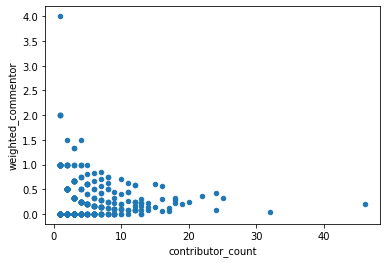

In [ ]:
df_comments.plot(x = 'contributor_count', y = 'weighted_commentor', kind = 'scatter')	

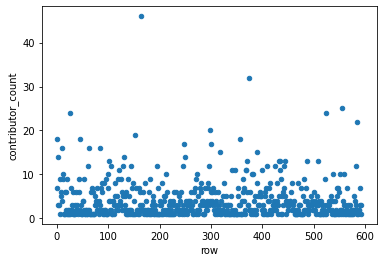

In [ ]:
df_comments.plot(x = 'row', y = 'contributor_count', kind = 'scatter')	

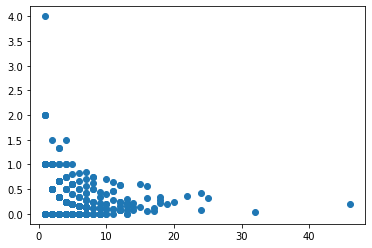

In [ ]:
y =  np.array( df_comments['weighted_emoji'].values.flatten().tolist() )
x =  np.array( df_comments['contributor_count'].values.flatten().tolist() )

# plot the data itself
plt.scatter(x, y)

#z = np.polyfit(x, y, 3)
#p = np.poly1d(z)

#add trendline to plot
#plt.plot(x, p(x))

## Sentiment Analysis

In [ ]:
#TESTING SENTIMENT ANALYZER

rows = []
#rows = [[i, i+1] for i in range(3)]

#parse each comment into list 
for issue in issue_dict.values():
    reaction_count = len(list(flatten(issue['comment_react'])))
    contributor = len(issue['comment_user'])
    create_at = str(issue['created_at'])[:10]
    rows.append( [create_at, contributor, reaction_count] )

#list into data frame
df_comments = pd.DataFrame(rows, columns=["date", "contributor_count", "emoji_count"])   

#drop issues with zero contributors
df_comments = df_comments.drop( df_comments[(df_comments.contributor_count == 0)].index )

#percentage commentors
df_comments['weighted_emoji'] = df_comments['emoji_count'] / df_comments['contributor_count']

In [ ]:
#from another piece of code:

df_sample.head()

date  contributor_count  \
675  2021-06-09                  7   
674  2021-06-10                 18   
673  2021-06-11                 14   
670  2021-06-12                  3   
672  2021-06-12                  0   

                                              comments  \
675  [I would agree with @RafaelDavisH that having ...   
674  [Could reproduce on: Mozilla/5.0 (iPad; CPU OS...   
673  [If I am not mistaken, the idea was to complet...   
670  [The test currently checks for two separate `c...   
672                                                 []   

                                             commentor  issue_id  
675  [26656284, 15801806, 6822714, 26656284, 682271...         1  
674  [51722130, 1884376, 6234475, 51722130, 6234475...         2  
673  [51722130, 20648924, 55016909, 51722130, 55016...         3  
670                     [36357875, 35785843, 36357875]         4  
672                                                 []         5

In [ ]:
df_sample['comments_string'] = [','.join(map(str, comment_list)) for comment_list in df_sample['comments']]


df_sample.head()

date  contributor_count  \
675  2021-06-09                  7   
674  2021-06-10                 18   
673  2021-06-11                 14   
670  2021-06-12                  3   
672  2021-06-12                  0   

                                              comments  \
675  [I would agree with @RafaelDavisH that having ...   
674  [Could reproduce on: Mozilla/5.0 (iPad; CPU OS...   
673  [If I am not mistaken, the idea was to complet...   
670  [The test currently checks for two separate `c...   
672                                                 []   

                                             commentor  issue_id  \
675  [26656284, 15801806, 6822714, 26656284, 682271...         1   
674  [51722130, 1884376, 6234475, 51722130, 6234475...         2   
673  [51722130, 20648924, 55016909, 51722130, 55016...         3   
670                     [36357875, 35785843, 36357875]         4   
672                                                 []         5   

                                       comments_string  
675  I would agree with @RafaelDavisH that having t...  
674  Could reproduce on: Mozilla/5.0 (iPad; CPU OS ...  
673  If I am not mistaken, the idea was to complete...  
670  The test currently checks for two separate `co...  
672

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import operator
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
 #test case all comments for one issue in one list (list of strings, ie. string = a comment w/in an issue)
df_sample["comments"]


0      [You mentioned [in different issue](https://gi...
1                                                     []
2                                                     []
3      [There isn't an issue per se. Goal is to have ...
4                                                     []
                             ...                        
671    [Good catch @ieahleen.  I think this is a bug ...
672                                                   []
673    [If I am not mistaken, the idea was to complet...
674    [Could reproduce on: Mozilla/5.0 (iPad; CPU OS...
675    [I would agree with @RafaelDavisH that having ...
Name: comments, Length: 676, dtype: object

In [ ]:
df_sample["sentiment_score"] = df_sample["comments_string"].apply(lambda x: sia.polarity_scores(x)["compound"])


In [ ]:
df_sample.head()

date  contributor_count  \
0  2022-06-14                  3   
1  2022-06-13                  0   
2  2022-06-13                  0   
3  2022-06-13                  1   
4  2022-06-12                  0   

                                            comments  \
0  [You mentioned [in different issue](https://gi...   
1                                                 []   
2                                                 []   
3  [There isn't an issue per se. Goal is to have ...   
4                                                 []   

                       commentor  \
0  [88248797, 5926192, 88248797]   
1                             []   
2                             []   
3                     [60067306]   
4                             []   

                                     comments_string  sentiment_score  
0  You mentioned [in different issue](https://git...           0.0940  
1                                                              0.0000  
2                                                              0.0000  
3  There isn't an issue per se. Goal is to have t...           0.5859  
4                                                              0.0000

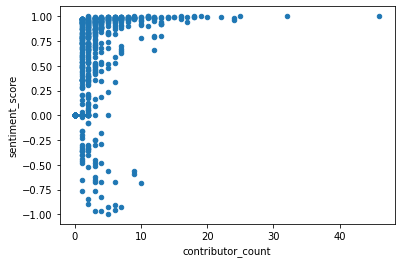

In [ ]:
df_sample.plot(x = 'contributor_count', y = 'sentiment_score', kind = 'scatter')	

In [ ]:
#df_sample["sentiment"] = np.select([df_sample["sentiment_score"] < 0, df_sample["sentiment_score"] == 0, df_sample["sentiment_score"] > 0], ['neg', 'neu', 'pos'])

In [ ]:
# using granularity of 1 comment from 1 issue = 1 row

result.head()

date  contributor_count  issue_id  commentor  \
0  2021-06-09                  7         1   26656284   
1  2021-06-09                  7         1   15801806   
2  2021-06-09                  7         1    6822714   
3  2021-06-09                  7         1   26656284   
4  2021-06-09                  7         1    6822714   

                                            comments  
0  I would agree with @RafaelDavisH that having t...  
1  My high level take is that allowing the transl...  
2  This is an example where the title of the chal...  
3  The case that started this discussion was a "s...  
4  > I think we do want to make it easier to make...

In [ ]:
result['sentiment_score'] = result["comments"].apply(lambda x: sia.polarity_scores(x)["compound"])

#treat % change from zero (inf)
result['sentiment_score'] = result['sentiment_score'].replace(0, 0.01)

result.head()

date  contributor_count  issue_id  commentor  \
0  2021-06-09                  7         1   26656284   
1  2021-06-09                  7         1   15801806   
2  2021-06-09                  7         1    6822714   
3  2021-06-09                  7         1   26656284   
4  2021-06-09                  7         1    6822714   

                                            comments  sentiment_score  \
0  I would agree with @RafaelDavisH that having t...           0.7415   
1  My high level take is that allowing the transl...           0.9868   
2  This is an example where the title of the chal...          -0.8016   
3  The case that started this discussion was a "s...           0.2075   
4  > I think we do want to make it easier to make...           0.8314   

   sentiment_change  sentiment_change_abs  
0               NaN                   NaN  
1          0.330816              0.330816  
2         -1.812323              1.812323  
3         -1.258857              1.258857  
4          3.006747              3.006747

In [ ]:
result['sentiment_change'] = result.groupby('issue_id').sentiment_score.pct_change()

result['sentiment_change_abs'] = result.sentiment_change.abs()

result.head()

###add control variables of senior commentors

date  contributor_count  issue_id  commentor  \
0  2021-06-09                  7         1   26656284   
1  2021-06-09                  7         1   15801806   
2  2021-06-09                  7         1    6822714   
3  2021-06-09                  7         1   26656284   
4  2021-06-09                  7         1    6822714   

                                            comments  sentiment_score  \
0  I would agree with @RafaelDavisH that having t...           0.7415   
1  My high level take is that allowing the transl...           0.9868   
2  This is an example where the title of the chal...          -0.8016   
3  The case that started this discussion was a "s...           0.2075   
4  > I think we do want to make it easier to make...           0.8314   

   sentiment_change  sentiment_change_abs  
0               NaN                   NaN  
1          0.330816              0.330816  
2         -1.812323              1.812323  
3         -1.258857              1.258857  
4          3.006747              3.006747

In [ ]:
#merge back to issue_id granalurity
#ref. https://stackoverflow.com/questions/46826773/how-can-i-merge-rows-by-same-value-in-a-column-in-pandas-with-aggregation-func

aggregation_functions = {'date': 'first', 'contributor_count': 'first', 'issue_id': 'first', 'sentiment_change_abs': 'mean'}

df_result_calc = result.groupby(result['issue_id']).aggregate(aggregation_functions)

df_result_calc.head()


date  contributor_count  issue_id  sentiment_change_abs
issue_id                                                               
1         2021-06-09                  7         1              1.288775
2         2021-06-10                 18         2             12.426521
3         2021-06-11                 14         3              6.856881
4         2021-06-12                  3         4             16.874493
6         2021-06-12                  3         6             44.159876

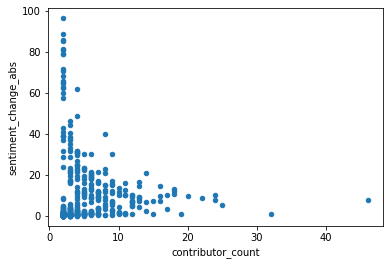

In [ ]:
#consider using DISTRIBUTION AS WELL
#ref. https://stackoverflow.com/questions/35674651/python-calculate-normal-distribution


df_result_calc.plot(x = 'contributor_count', y = 'sentiment_change_abs', kind = 'scatter')	

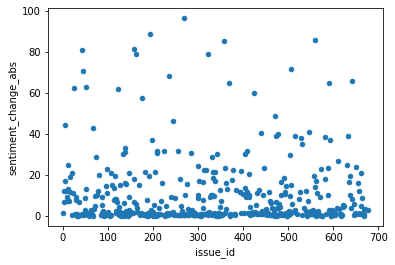

In [ ]:
df_result_calc.plot(x = 'issue_id', y = 'sentiment_change_abs', kind = 'scatter')	

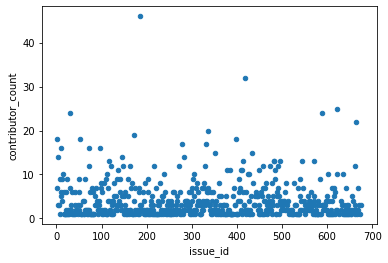

In [ ]:
#draw back, contributors are not growing with time?

df_result_calc.plot(x = 'issue_id', y = 'contributor_count', kind = 'scatter')	

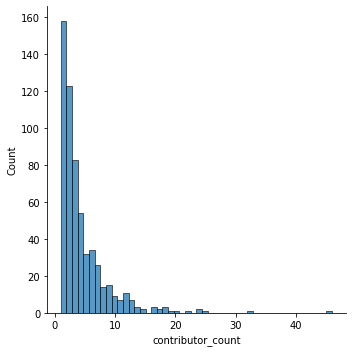

In [ ]:
import statistics as st

sns.displot(df_result_calc, x = "contributor_count")

## introducing control variables

In [ ]:
#seniority of a person at time of commenting

#penalize someone that is super active

result.head()

date  contributor_count  issue_id  commentor  \
0  2021-06-09                  7         1   26656284   
1  2021-06-09                  7         1   15801806   
2  2021-06-09                  7         1    6822714   
3  2021-06-09                  7         1   26656284   
4  2021-06-09                  7         1    6822714   

                                            comments  sentiment_score  \
0  I would agree with @RafaelDavisH that having t...           0.7415   
1  My high level take is that allowing the transl...           0.9868   
2  This is an example where the title of the chal...          -0.8016   
3  The case that started this discussion was a "s...           0.2075   
4  > I think we do want to make it easier to make...           0.8314   

   sentiment_change  sentiment_change_abs  
0               NaN                   NaN  
1          0.330816              0.330816  
2         -1.812323              1.812323  
3         -1.258857              1.258857  
4          3.006747              3.006747

In [ ]:

result['commentor_adj'] = result.groupby('commentor').cumcount()+1

result['commentor_stdev'] = st.stdev(result['commentor_adj'])

result['commentor_1sd'] = (result['commentor_adj'] <= result['commentor_stdev'] * 1)

result['commentor_2sd'] = (result['commentor_adj'] <= result['commentor_stdev'] * 2) & (result['commentor_adj'] > result['commentor_stdev'] * 1)

result['commentor_3sd'] = (result['commentor_adj'] <= result['commentor_stdev'] * 3) & (result['commentor_adj'] > result['commentor_stdev'] * 2)

#drop nan of % change
#result = result[result['sentiment_change_abs'].notna()]

result.head()

date  contributor_count  issue_id  commentor  \
0  2021-06-09                  7         1   26656284   
1  2021-06-09                  7         1   15801806   
2  2021-06-09                  7         1    6822714   
3  2021-06-09                  7         1   26656284   
4  2021-06-09                  7         1    6822714   

                                            comments  sentiment_score  \
0  I would agree with @RafaelDavisH that having t...           0.7415   
1  My high level take is that allowing the transl...           0.9868   
2  This is an example where the title of the chal...          -0.8016   
3  The case that started this discussion was a "s...           0.2075   
4  > I think we do want to make it easier to make...           0.8314   

   sentiment_change  sentiment_change_abs  commentor_adj  commentor_stdev  \
0               NaN                   NaN              1        57.166531   
1          0.330816              0.330816              1        57.166531   
2         -1.812323              1.812323              1        57.166531   
3         -1.258857              1.258857              2        57.166531   
4          3.006747              3.006747              2        57.166531   

   commentor_1sd  commentor_2sd  commentor_3sd  
0           True          False          False  
1           True          False          False  
2           True          False          False  
3           True          False          False  
4           True          False          False

In [ ]:
#test data 
result_1sd = result[result.commentor_1sd]


In [ ]:
aggregation_functions = {'date': 'first', 'contributor_count': 'first', 'issue_id': 'first', 'sentiment_change_abs': 'mean'}

result_1sd_calc = result.groupby(result_1sd['issue_id']).aggregate(aggregation_functions)

#drop nan (ie. no exchange of comments w/in an issue)
result_1sd_calc = result_1sd_calc.dropna()

result_1sd_calc.head()

date  contributor_count  issue_id  sentiment_change_abs
issue_id                                                               
1.0       2021-06-09                  7         1              1.288775
2.0       2021-06-10                 18         2             12.426521
3.0       2021-06-11                 14         3              6.856881
4.0       2021-06-12                  3         4             16.874493
6.0       2021-06-12                  3         6             44.159876

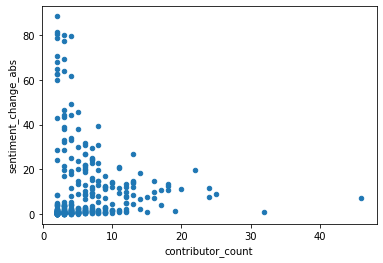

In [ ]:
result_1sd_calc.plot(x = 'contributor_count', y = 'sentiment_change_abs', kind = 'scatter')	


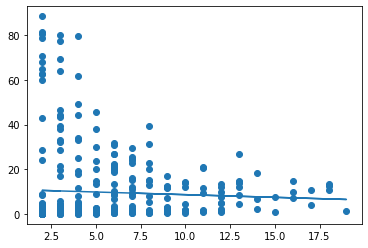

In [ ]:
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

from numpy import array

#regression

#y = mx + b
#change_sentiment = contributor count

df_regression = result_1sd_calc[result_1sd_calc.contributor_count < 20]


x = array( df_regression['contributor_count'] )
y = array( df_regression['sentiment_change_abs'] )

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

#model for polynomial regression
model = LinearRegression()
model.fit(x, y)

ypred = model.predict(x) 
ypred.shape

plt.scatter(x, y)
plt.plot(x, ypred)

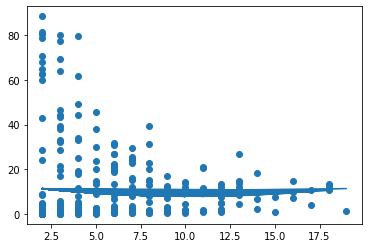

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

#regression

#y = mx + b
#change_sentiment = contributor count

poly = PolynomialFeatures(degree = 2, include_bias = False)

df_regression = result_1sd_calc[result_1sd_calc.contributor_count < 20]

x = array( df_regression['contributor_count'] )
y = array( df_regression['sentiment_change_abs'] )


xp = poly.fit_transform(x.reshape(-1, 1))
#y = y.reshape(-1, 1)

#model for polynomial regression
model_poly = LinearRegression()
model_poly.fit(xp, y)

ypred = model_poly.predict(xp) 
ypred.shape

plt.scatter(x, y)
plt.plot(x, ypred)


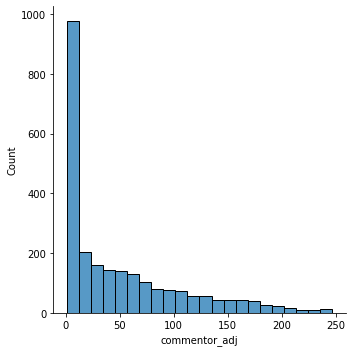

In [ ]:
#distribution of commentor's tenure
sns.displot(result, x = "commentor_adj")

In [ ]:
#seniority of comment at time of commenting

## Star History

In [ ]:
#using Github Repo Search API
#ref. https://towardsdatascience.com/top-30-github-python-projects-at-the-beginning-of-2022-86b1e3dad1a

url = 'https://api.github.com/search/repositories?q=language:python&sort=stars&order=desc'

#use request module to get url's data
results = requests.get(url)
#conver to python dictionary
results_dict = results.json()

#top 30 repos (defualt page size =30)
repos = results_dict['items']
len(repos)

repo_df = pd.DataFrame(repos)


repo_df_clean = repo_df[['name', 'full_name', 'html_url', 'created_at', 'stargazers_count', 'watchers', 'forks', 'open_issues']]
repo_df_clean['created_at'] = pd.to_datetime(repo_df_clean['created_at'])
repo_df_clean['created_year'] = repo_df_clean['created_at'].dt.year
repo_df_clean['years_on_github'] = 2022 - repo_df_clean['created_at'].dt.year

repo_df_clean.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

name                         full_name  \
0           public-apis           public-apis/public-apis   
1  system-design-primer  donnemartin/system-design-primer   
2        awesome-python              vinta/awesome-python   
3       Python-100-Days         jackfrued/Python-100-Days   
4            youtube-dl               ytdl-org/youtube-dl   

                                            html_url  \
0         https://github.com/public-apis/public-apis   
1  https://github.com/donnemartin/system-design-p...   
2            https://github.com/vinta/awesome-python   
3       https://github.com/jackfrued/Python-100-Days   
4             https://github.com/ytdl-org/youtube-dl   

                 created_at  stargazers_count  watchers  forks  open_issues  \
0 2016-03-20 23:49:42+00:00            196118    196118  22598            2   
1 2017-02-26 16:15:28+00:00            183676    183676  33436          313   
2 2014-06-27 21:00:06+00:00            130014    130014  21281          252   
3 2018-03-01 16:05:52+00:00            119772    119772  45776          643   
4 2010-10-31 14:35:07+00:00            110725    110725   7842         4727   

   created_year  years_on_github  
0          2016                6  
1          2017                5  
2          2014                8  
3          2018                4  
4          2010               12

In [ ]:
pd.set_option('max_colwidth', None)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)
#reset 
#pd.reset_option(‚Äúmax_columns‚Äù)
repo_df.loc[repo_df['id'] == 123458551]


id                           node_id             name  \
0  123458551  MDEwOlJlcG9zaXRvcnkxMjM0NTg1NTE=  Python-100-Days   

                   full_name  private  \
0  jackfrued/Python-100-Days    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      owner  \
0  {'login': 'jackfrued', 'id': 7474657, 'node_id': 'MDQ6VXNlcjc0NzQ2NTc=', 'avatar_url': 'https://avatars.githubusercontent.com/u/7474657?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jackfrued', 'html_url': 'https://github.com/jackfrued', 'followers_url': 'https://api.github.com/users/jackfrued/followers', 'following_url': 'https://api.github.com/users/jackfrued/following{/other_user}', 'gists_url': 'https://api.github.com/users/jackfrued/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jackfrued/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jackfrued/subscriptions', 'organizations_url': 'https://api.github.com/users/jackfrued/orgs', 'repos_url': 'https://api.github.com/users/jackfrued/repos', 'events_url': 'https://api.github.com/users/jackfrued/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jackfrued/received_events', 'type': 'User', 'site_admin': False}   

                                       html_url          description   fork  \
0  https://github.com/jackfrued/Python-100-Days  Python - 100Â§©‰ªéÊñ∞ÊâãÂà∞Â§ßÂ∏à  False   

                                                      url  \
0  https://api.github.com/repos/jackfrued/Python-100-Days   

                                                      forks_url  \
0  https://api.github.com/repos/jackfrued/Python-100-Days/forks   

                                                               keys_url  \
0  https://api.github.com/repos/jackfrued/Python-100-Days/keys{/key_id}   

                                                                     collaborators_url  \
0  https://api.github.com/repos/jackfrued/Python-100-Days/collaborators{/collaborator}   

                                                      teams_url  \
0  https://api.github.com/repos/jackfrued/Python-100-Days/teams   

                                                      hooks_url  \
0  https://api.github.com/repos/jackfrued/Python-100-Days/hooks   

                                                                issue_events_url  \
0  https://api.github.com/repos/jackfrued/Python-100-Days/issues/events{/number}   

                                                      events_url  \
0  https://api.github.com/repos/jackfrued/Python-100-Days/events   

                                                             assignees_url  \
0  https://api.github.com/repos/jackfrued/Python-100-Days/assignees{/user}   

                                                               branches_url  \
0  https://api.github.com/repos/jackfrued/Python-100-Days/branches{/branch}   

                                                      tags_url  \
0  https://api.github.com/repos/jackfrued/Python-100-Days/tags   

                                                                blobs_url  \
0  https

In [ ]:
repo_df.columns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement star-history (from versions: none)
ERROR: No matching distribution found for star-history


In [ ]:
#stars overtime

url = 'https://api.github.com/repos/freeCodeCamp/freeCodeCamp/stargazers'


#use request module to 
repo_response = requests.get(url,headers={'Accept': 'application/vnd.github.v3.star+json'})
#stars = results.headers

print(repo_response.json())



[{'starred_at': '2014-12-24T20:05:35Z', 'user': {'login': 'BerkeleyTrue', 'id': 6775919, 'node_id': 'MDQ6VXNlcjY3NzU5MTk=', 'avatar_url': 'https://avatars.githubusercontent.com/u/6775919?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/BerkeleyTrue', 'html_url': 'https://github.com/BerkeleyTrue', 'followers_url': 'https://api.github.com/users/BerkeleyTrue/followers', 'following_url': 'https://api.github.com/users/BerkeleyTrue/following{/other_user}', 'gists_url': 'https://api.github.com/users/BerkeleyTrue/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/BerkeleyTrue/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/BerkeleyTrue/subscriptions', 'organizations_url': 'https://api.github.com/users/BerkeleyTrue/orgs', 'repos_url': 'https://api.github.com/users/BerkeleyTrue/repos', 'events_url': 'https://api.github.com/users/BerkeleyTrue/events{/privacy}', 'received_events_url': 'https://api.github.com/users/BerkeleyTrue/received_events', 

## Contributors

In [ ]:

user_str, repo_str = 'https://github.com/freeCodeCamp/freeCodeCamp'.replace("https://github.com/", "").split("/")

user = git_obj.get_user(user_str)
repo = user.get_repo(repo_str)


#total contributors
repo.get_contributors().totalCount

406

In [ ]:
url = 'https://api.github.com/repos/freeCodeCamp/freeCodeCamp/contributors?per_page=1&anon=true'


#use request module to get url's data
results = requests.get(url)

test = results.headers


In [ ]:
dict(test)['Link']

'<https://api.github.com/repositories/28457823/contributors?per_page=1&anon=true&page=2>; rel="next", <https://api.github.com/repositories/28457823/contributors?per_page=1&anon=true&page=4884>; rel="last"'

In [ ]:
repo_df = pd.DataFrame(repos)

In [ ]:
#convert to json string
test_dict = json.dumps(dict(test))

test_dict

'{"Server": "GitHub.com", "Date": "Sun, 12 Jun 2022 19:58:37 GMT", "Content-Type": "application/json; charset=utf-8", "Cache-Control": "public, max-age=60, s-maxage=60", "Vary": "Accept, Accept-Encoding, Accept, X-Requested-With", "ETag": "W/\\"e5f9c870f98f312133f917228ddd147bcec8a21f96b96762a18aa5f5a463eeea\\"", "Last-Modified": "Sun, 12 Jun 2022 19:37:37 GMT", "X-GitHub-Media-Type": "github.v3; format=json", "Link": "<https://api.github.com/repositories/28457823/contributors?per_page=1&anon=true&page=2>; rel=\\"next\\", <https://api.github.com/repositories/28457823/contributors?per_page=1&anon=true&page=4884>; rel=\\"last\\"", "Access-Control-Expose-Headers": "ETag, Link, Location, Retry-After, X-GitHub-OTP, X-RateLimit-Limit, X-RateLimit-Remaining, X-RateLimit-Used, X-RateLimit-Resource, X-RateLimit-Reset, X-OAuth-Scopes, X-Accepted-OAuth-Scopes, X-Poll-Interval, X-GitHub-Media-Type, X-GitHub-SSO, X-GitHub-Request-Id, Deprecation, Sunset", "Access-Control-Allow-Origin": "*", "Strict

In [ ]:
x = re.findall('true&page=(\d+)', test_dict)

x[1]

'4884'

## Apendix Code

In [ ]:
%time
#dir(comment) #all attributes for the obj.

issue_content.get_comments()

In [ ]:
#####################################
###Step 2 Load Issue Contents to DICT
print('Step 2: Load Issues to DICT')

#progress bar
max_count = len(issue_content_list) #max loops (ie. isuues) needed
status_bar_ii = IntProgress(min = 1, max = max_count) # create status-bar (starts at 1)
display(status_bar_ii)

#intialize: empty dict
repo_dict = {}
total_count = 'out of ' + str(max_count) + ' issues' #for current issue dynamic update
core_rate_limit = git_obj.get_rate_limit().core

for issue_content in issue_content_list:
  #dynamically print current issue & API limit
  print('process issue: ', f'\r{status_bar_ii.value, total_count, core_rate_limit}', end = '', flush = True)

  #API Throttle
  try:
    issue_dict = {'title': issue_content.title, #title of issue
                  'body': issue_content.body, #original comment
                  'created_at': issue_content.created_at, #dtm of issue
                  'state': issue_content.state,
                  'comments': [comment.body for comment in issue_content.get_comments()], #follow-up comments
                  'comment_user': [comment.user.id for comment in issue_content.get_comments()], #follow-up commentor user-ID
                  #reactions for ea. comment in ea. issue
                  'comment_react': [ 
                                    [reaction.content for reaction in comment.get_reactions()] #nested loop
                                    for comment in issue_content.get_comments()]
                  }
                  
    #add to dict: ea. Issue (many comments) belongs to one key in dict
    repo_dict[issue_content.number] = issue_dict

    #for status bar:
    status_bar_ii.value += 1 #update status-bar
    #for calculating Github API limit:
    core_rate_limit = git_obj.get_rate_limit().core
    
    if core_rate_limit.remaining <= 50:
      reset_timestamp = calendar.timegm(core_rate_limit.reset.timetuple()) #returns the corresponding Unix timestamp value
      sleep_time = reset_timestamp - calendar.timegm(time.gmtime()) + 5 #add 5 sec (1-hr reset time calc. at start of execution)
      print('\nsleeping for:', sleep_time/60, 'mins;', ' at issue:', status_bar_ii.value, '###API hourly refresh limit: ', core_rate_limit)
      time.sleep(sleep_time) 

  #after sleeping, continue back into above loop  
  except:
    continue

#saving DICT to file
with open('repo_dict.pkl', 'wb') as f:
    pickle.dump(repo_dict, f)

print('\n***repo_dict: processing Issues into DICT complete!***', end = '\n')

In [ ]:
#explore other code

from github import Github
# using username and password
# or using an access token
g = Github("***************************")
for repo in g.get_user().get_repos():
    print(repo.name)

print("**********Get Current Repos**********")
user = g.get_user()
user.login
print(user.login)
repo = g.get_repo("<any-repo>/<any-repo>")
repo.name
print(repo.name)
print("********Get the Repo Topics**************")

repo = g.get_repo("<any-repo>/<any-repo>")
repo.get_topics()
print(repo.get_topics())

print("*****Get the Star Count*************")
repo = g.get_repo("<any-repo>/<any-repo>")
repo.stargazers_count
print(repo.stargazers_count)
print("********Get the Open Issues*********")
repo = g.get_repo("<any-repo>/<any-repo>")
open_issues = repo.get_issues(state='open')
for issue in open_issues:
    print(issue)

print("******Get the Branch Count*******")
repo = g.get_repo("<any-repo>/<any-repo>")
print(list(repo.get_branches()))

NameError: ignored

In [ ]:
#input url
#repo_url = 'https://github.com/freeCodeCamp/freeCodeCamp'
#repo_url = 'https://github.com/lse-my470/assignment-8-centipede'
repo_url = 'https://github.com/borisdayma/dalle-mini'


user_str, repo_str = repo_url.replace("https://github.com/", "").split("/")
user = git_obj.get_user(user_str)
repo = user.get_repo(repo_str)
issues = repo.get_issues(state="all")


#####################################
###Step 1 Load All Issues
print('Step 1: Load all Issues')

#progress bar
#ref. https://stackoverflow.com/questions/38861829/how-do-i-implement-a-progress-bar
max_count = round(issues.totalCount / 30) #max loops (ie. pages) needed
status_bar = IntProgress(min = 0, max = max_count) # create status-bar
display(status_bar)

#intialize: empty list
issue_content_list = []
total_page = 'out of ' + str(max_count) + ' pages' #for current page dynamic update
core_rate_limit = git_obj.get_rate_limit().core

#issues-obj contains all the issues + PR of a repo
#ea. page (more issues = more pages) contains a list of issues, only keep issues that are real-git-issues (not PRs)
for page_num in range(round(issues.totalCount / 30) + 1):
  #print('page: ', page_num, 'out of', max_count, 'API limit: ', core_rate_limit)
  #dynamically print current page_num & API limit
  print('page: ', f'\r{page_num, total_page, core_rate_limit}', end = '', flush = True)

  #API throttle
  try:

    #normal operations
    for issue_content in issues.get_page(page_num):
      if not issue_content.pull_request:
        issue_content_list.append(issue_content)

    #for status bar (before next page_num):
    status_bar.value += 1 #update status-bar
    #for calculating Github API limit:
    core_rate_limit = git_obj.get_rate_limit().core

    if core_rate_limit.remaining <= 100:
      reset_timestamp = calendar.timegm(core_rate_limit.reset.timetuple()) #returns the corresponding Unix timestamp value
      sleep_time = reset_timestamp - calendar.timegm(time.gmtime()) + 5 #add 5 seconds to be sure the rate limit has been reset
      print('sleeping for 1-hr at page: ', page_num, 'API limit: ', core_rate_limit)
      time.sleep(sleep_time)

  #after sleeping, continue back into above loop  
  except:
    continue

#####################################
print('issue_content_list: loading Repo Issues Complete!')


#####################################
###Step 2 Load Issue Contents to DICT
print('Step 2: Load Issues to DICT')

#progress bar
max_count = len(issue_content_list) #max loops (ie. pages) needed
status_bar = IntProgress(min = 0, max = max_count) # create status-bar
display(status_bar)

#intialize: empty dict
rtn = {}
total_page = 'out of ' + str(max_count) + ' pages' #for current page dynamic update
core_rate_limit = git_obj.get_rate_limit().core

for issue_content in issue_content_list:
  iss_dict = {"title": issue_content.title, #title of issue
              "body": issue_content.body, #original comment
              "create_dt": issue_content.created_at, #dtm of issue
              "state": issue_content.state,
              "comments": [comment.body for comment in issue_content.get_comments()], #follow-up comments
              "comment_user": [comment.user.id for comment in issue_content.get_comments()], #follow-up commentor user-ID
              "comment_reaction": [reaction.content for reaction in comment.get_reactions() for comment in issue_content.get_comments()] #follow-up commentor user-ID
              }
  #each Issue (many comments) belongs to one key in dictionary
  rtn[issue_content.number] = iss_dict


#progress bar
#ref. https://stackoverflow.com/questions/38861829/how-do-i-implement-a-progress-bar
max_count = round(issues.totalCount / 30) #max loops (ie. pages) needed
status_bar = IntProgress(min = 0, max = max_count) # create status-bar
display(status_bar)